# Package and Data Importing

In [42]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from category_encoders import OneHotEncoder
from xgboost import XGBClassifier

df = pd.read_csv('../assets/churn_ds.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [43]:
# Graphing features for exploratory analysis

import plotly.express as px

px.bar(df, x='Contract', y='tenure', color='Churn')

# Data Cleaning and Train/Validate/Test Split

In [44]:
def fix_float(cell):
  try: 
    return float(cell)
  except: 
    print(cell)
    return np.NaN

### Feature / Target Split 
- By using this set of data our goal is to predict if a customer is likely to continue service with the provider. The **Target** will be if the customer has Churned - that means they have discontinued service. Churn is a term used in marketing to describe when a customer comes into the system and leaves rather quickly, yeild a low CLV. The Feature we will be using to predict this will be a combination of person charateristics: Age, Gender, Family. Service offers they currently have with the provider: Phone Service, Internet Service, Online Security, Streaming TV, etc. Also Subscription details: Contract, Billing, Payment Method, Monthly and Total Charges. 

In [45]:
# Cleaning Wrangle function 

def wrangle(X):
    
    X = X.copy()
    
    # fixing column to change to float
    X['TotalCharges'] = X['TotalCharges'].apply(fix_float)
                                                  
    # replacing Yes/No with True/False
    columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']                                              
    for col in columns:
        X[col] = X[col].apply(lambda cell: cell.lower() == 'yes')

    y = X['Churn']    
        
    X.drop(['customerID', 'Churn'], axis=1, inplace=True)
                                                  
    return X, y

X, y = wrangle(df)

In [46]:
wrangle(df);

In [47]:
# Checking wrangle function was effective
print(X.shape)
print(y.shape)

(7043, 19)
(7043,)


In [48]:
# Train Val split 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.30, stratify=y, random_state=42)

In [49]:
# Val test split 
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.50, stratify=y_val, random_state=42)

In [50]:
# checking for CV sizes
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4930, 19)
(4930,)
(1056, 19)
(1056,)
(1057, 19)
(1057,)


In [51]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5557,Female,0,False,False,5,True,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,False,Electronic check,80.20,384.25
2270,Female,1,False,False,3,True,No,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,True,Electronic check,86.85,220.95
6930,Female,0,True,False,3,True,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,True,Credit card (automatic),75.15,216.75
2257,Female,0,False,False,60,True,Yes,DSL,No,No,Yes,Yes,Yes,Yes,One year,False,Credit card (automatic),80.55,4847.05
898,Female,0,False,False,12,True,No,Fiber optic,Yes,No,No,Yes,Yes,Yes,Month-to-month,True,Bank transfer (automatic),98.90,1120.95


In [52]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4930 entries, 5557 to 5639
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4930 non-null   object 
 1   SeniorCitizen     4930 non-null   int64  
 2   Partner           4930 non-null   bool   
 3   Dependents        4930 non-null   bool   
 4   tenure            4930 non-null   int64  
 5   PhoneService      4930 non-null   bool   
 6   MultipleLines     4930 non-null   object 
 7   InternetService   4930 non-null   object 
 8   OnlineSecurity    4930 non-null   object 
 9   OnlineBackup      4930 non-null   object 
 10  DeviceProtection  4930 non-null   object 
 11  TechSupport       4930 non-null   object 
 12  StreamingTV       4930 non-null   object 
 13  StreamingMovies   4930 non-null   object 
 14  Contract          4930 non-null   object 
 15  PaperlessBilling  4930 non-null   bool   
 16  PaymentMethod     4930 non-null   objec

# Baseline

In [53]:
# Baseline

y_train.value_counts(normalize=True)

False    0.734686
True     0.265314
Name: Churn, dtype: float64

### Baseline for Churn
- From the above baseline we can see our mean values for predicting the positive charatertic of Churn is 73.5%. Our Goal is to create a model in which we can predict to a higher level of certaintity if a customer will decide to terminate service. As well as what features are indicative of this.


# Fitting Different Model Types

### Initial Simple Model: Logistic Regression 

In [54]:
lin_model = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(strategy='median'), 
    LogisticRegression()
)

lin_model.fit(X_train, y_train)

/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender', 'MultipleLines',
                                     'InternetService', 'OnlineSecurity',
                                     'OnlineBackup', 'DeviceProtection',
                                     'TechSupport', 'StreamingTV',
                                     'StreamingMovies', 'Contract',
                                     'PaymentMethod'])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('logisticregression', LogisticRegression())])

In [55]:
print('Training Accuracy: ', lin_model.score(X_train, y_train))
print('Validation Accuracy:', lin_model.score(X_val, y_val))


Training Accuracy:  0.8056795131845842
Validation Accuracy: 0.8058712121212122


### Hyper Parameter Tuning for Logistic Regression Model

In [56]:
# pipeline for model
lin_model_tuned = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(), 
    LogisticRegression()
)

# Params for grid search
params = {
    'logisticregression__penalty' : ['l1', 'l2'],
    'logisticregression__C' : np.logspace(-4, 4, 20), 
    'logisticregression__solver': ['lbfgs', 'liblinear'], 
    'logisticregression__max_iter': range(50,150, 25), 
}

# Grid Search object
gridcv = GridSearchCV(
    lin_model_tuned,
    param_grid = params, 
    n_jobs=-1, 
    cv=5, 
    scoring='accuracy', 
    verbose= True, 
    return_train_score= True,

)

# fit on data
best_gridcv = gridcv.fit(X_train, y_train)

# Print Best accuracy score
print(best_gridcv.score(X_val, y_val))

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  2.9min finished
/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



0.8096590909090909


/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



- After Tuning the model, it looks like the accuracy has improved just slightly. This leads us 

### Random Forest Model

In [57]:
# basic pipeline model
RF_model = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier()
)

RF_model.fit(X_train, y_train)
RF_model.score(X_val, y_val)

/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



0.7784090909090909

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_prob_rf = RF_model.predict_proba(X_val)[:, -1]

roc_auc_score(y_val, y_pred_prob_rf)

0.8144421944035346

- Due to initual Validation score being very low compared to other models, Not going to further tune this model

### Tree Based Model + Hyper Param tuning

In [59]:
tree_model = make_pipeline(
    ce.OneHotEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=6)
)

param_distributions= {
    'xgbclassifier__max_depth': range(4,6,1), 
}

search = RandomizedSearchCV(
    tree_model,
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    verbose= 5, 
    return_train_score= True,

)
search.fit(X_train, y_train)
tree_model_best = search.best_estimator_

/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning:

The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] xgbclassifier__max_depth=4 ......................................
[CV]  xgbclassifier__max_depth=4, score=(train=0.900, test=0.810), total=   0.8s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



[CV]  xgbclassifier__max_depth=4, score=(train=0.891, test=0.808), total=   0.8s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



[CV]  xgbclassifier__max_depth=4, score=(train=0.896, test=0.790), total=   0.8s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



[CV]  xgbclassifier__max_depth=4, score=(train=0.896, test=0.788), total=   0.8s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s
/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



[CV]  xgbclassifier__max_depth=4, score=(train=0.901, test=0.767), total=   0.8s
[CV] xgbclassifier__max_depth=5 ......................................


/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



[CV]  xgbclassifier__max_depth=5, score=(train=0.938, test=0.793), total=   0.8s
[CV] xgbclassifier__max_depth=5 ......................................


/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



[CV]  xgbclassifier__max_depth=5, score=(train=0.930, test=0.794), total=   0.8s
[CV] xgbclassifier__max_depth=5 ......................................


/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



[CV]  xgbclassifier__max_depth=5, score=(train=0.928, test=0.802), total=   0.8s
[CV] xgbclassifier__max_depth=5 ......................................


/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



[CV]  xgbclassifier__max_depth=5, score=(train=0.935, test=0.782), total=   0.8s
[CV] xgbclassifier__max_depth=5 ......................................


/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



[CV]  xgbclassifier__max_depth=5, score=(train=0.937, test=0.764), total=   0.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.1s finished
/Users/trevorjames/PycharmProjects/Unit-2-Build-Week/venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [60]:
tree_model_best.score(X_val, y_val)

0.7840909090909091

- Sticking with Logistic Regression seems like the way to go

# Plotting Results

In [61]:
# Classification Report
from sklearn.metrics import classification_report

y_pred_lin = best_gridcv.predict(X_val)

report1 = classification_report(y_val, y_pred_lin)
print(report1)

              precision    recall  f1-score   support

       False       0.85      0.90      0.87       776
        True       0.67      0.56      0.61       280

    accuracy                           0.81      1056
   macro avg       0.76      0.73      0.74      1056
weighted avg       0.80      0.81      0.80      1056



In [62]:
# Classification Report
from sklearn.metrics import classification_report

y_pred_XG = tree_model_best.predict(X_val)

report2 = classification_report(y_val, y_pred_XG)
print(report2)

              precision    recall  f1-score   support

       False       0.84      0.88      0.86       776
        True       0.61      0.52      0.56       280

    accuracy                           0.78      1056
   macro avg       0.72      0.70      0.71      1056
weighted avg       0.78      0.78      0.78      1056



In [63]:
# Classification Report
from sklearn.metrics import classification_report

y_pred_RF = RF_model.predict(X_val)

report3 = classification_report(y_val, y_pred_RF)
print(report3)

              precision    recall  f1-score   support

       False       0.83      0.88      0.85       776
        True       0.60      0.49      0.54       280

    accuracy                           0.78      1056
   macro avg       0.71      0.69      0.70      1056
weighted avg       0.77      0.78      0.77      1056



### ROC - AUC Curves + Comparison

LR Model ROC-AUC Score: 0.8437384941089838


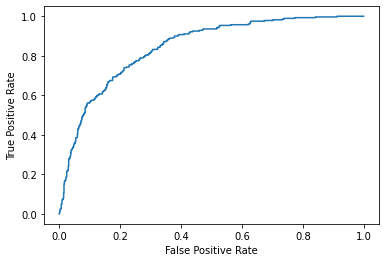

In [78]:
# Looking into ROC-AUC score for Linear Regression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_prob = best_gridcv.predict_proba(X_val)[:, -1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

dfroc = pd.DataFrame({'False Positive Rate': fpr, 
                     'True Positive Rate': tpr,
                    'Threshold': np.round(thresholds, 2)})


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('LR Model ROC-AUC Score:', roc_auc_score(y_val, y_pred_prob))
plt.plot(fpr, tpr);

Text(0, 0.5, 'True Positive Rate')

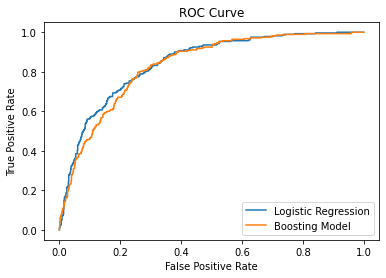

In [75]:
# Obtaining ROC + COmparing it to LR model
y_pred_prob_t = tree_model_best.predict_proba(X_val)[:, -1]

# Creating ROC-AUC Curve
fpr_t, tpr_t, thresholds_t = roc_curve(y_val, y_pred_prob_t)

#DF for ROC-AUC information 
dfroc_t = pd.DataFrame({'False Positive Rate': fpr, 
                     'True Positive Rate': tpr,
                    'Threshold': np.round(thresholds, 2)})


#Plotting both lines on the same graph
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot(fpr_t, tpr_t, label='Boosting Model')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [79]:
# ROC_AUC for both models
print('LR Model ROC-AUC Score:', roc_auc_score(y_val, y_pred_prob))
print('XG Model ROC-AUC Score:', roc_auc_score(y_val, y_pred_prob_t))

LR Model ROC-AUC Score: 0.8437384941089838
XG Model ROC-AUC Score: 0.8315951767304861


### Permutation Dependence

In [80]:
from sklearn.inspection import permutation_importance

In [81]:
result = permutation_importance(best_gridcv, X_val, y_val, 
                                n_repeats=5, random_state=0)

In [82]:
df1 = pd.DataFrame({'Feature': X_val.columns,
                   'Importances': np.round(result['importances_mean'], 3),
                   'importances_std': result['importances_std']})

In [83]:
df1.sort_values(by='Importances', ascending=False)

,Feature,Importances,importances_std
4,tenure,0.151,0.011433
18,TotalCharges,0.032,0.007177
7,InternetService,0.019,0.003692
16,PaymentMethod,0.008,0.004561
6,MultipleLines,0.007,0.003420
11,TechSupport,0.006,0.006631
14,Contract,0.005,0.005047
1,SeniorCitizen,0.005,0.001339
15,PaperlessBilling,0.004,0.002910
13,StreamingMovies,0.004,0.001797


In [84]:
px.bar(df1, x='Feature', y='Importances')

### PDP Plots : Islolate + Interact

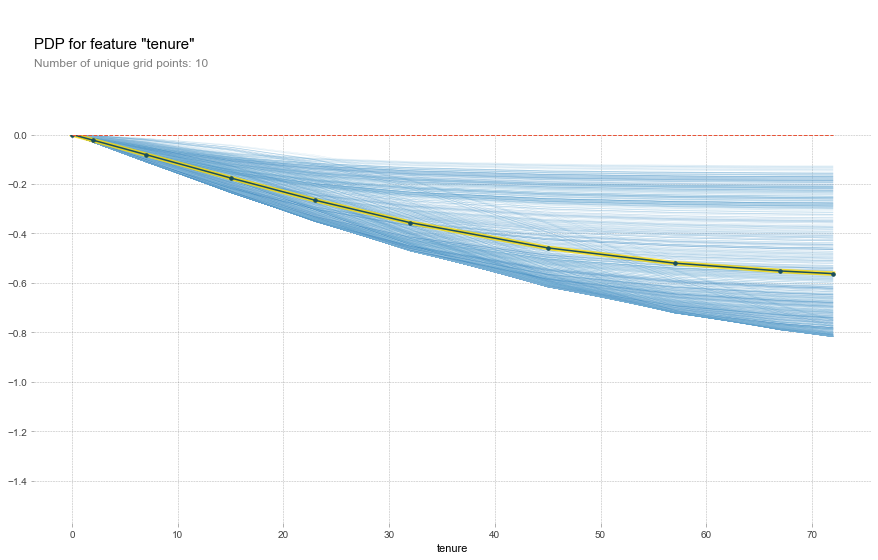

In [86]:
# PDP looking directly at Tenure and its interaction with the target Churn

from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'tenure'

isolated = pdp_isolate(
    model=best_gridcv, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True);


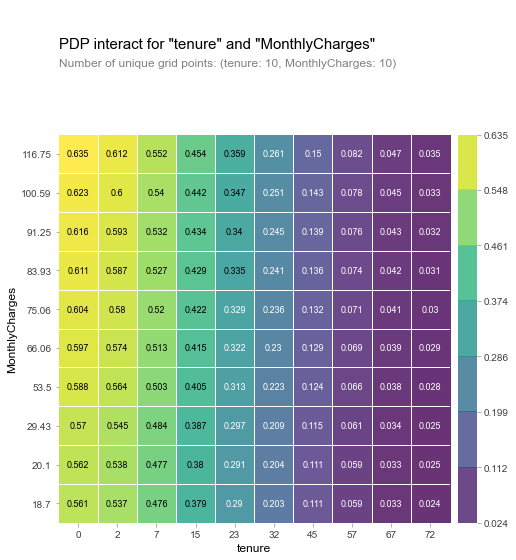

In [87]:
# PDP on Tenure and Monthly Charges 
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['tenure', 'MonthlyCharges']

interaction = pdp_interact(
    model=best_gridcv, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

# Running Model on Test Data

In [88]:
# Accuracy for Test set
best_gridcv.score(X_test, y_test)

0.7984862819299905

In [89]:
# ROC-AUC Score for Test set 
y_pred_prob_test = best_gridcv.predict_proba(X_test)[:, -1]

roc_auc_score(y_test, y_pred_prob_test)


0.8446958579447481

In [94]:
# Classification report for test set
y_pred_test = best_gridcv.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.83      0.91      0.87       776
        True       0.67      0.48      0.56       281

    accuracy                           0.80      1057
   macro avg       0.75      0.70      0.71      1057
weighted avg       0.79      0.80      0.79      1057

